In [1]:
using LinearAlgebra
using Test
import Base.*, Base.\, Base.setindex!, Base.getindex, Base.size, Base.firstindex, Base.lastindex

## Metoda konjugiranih gradientov za razpršene matrike

Tip RazprsenaMatrika je definiran da se prihrani prostor in se ne hrani ničelnih elementov. Neničelni elementi se hranijo v matriki V, njihove pozicije v vrstici pa v matriki I, tako da V(i, j) = M(i, I(i, j)).

Pri pridobivanju elementa se pogleda v matriko I. Pri postavljanju elementa pa se izvede glede na postavljeno vrednost, če damo element na 0 se njegova pozicija in vrednost odstrani, sicer pa doda oz zamenja obstoječo.

Pri množenju direkno množimo z uporabo vrstic matrik I in V.

Metoda konjugiranih gradientov rešuje sistem lineranih enačb, kjer je matrika sistema simetrična pozitivno definitna. Konvergenca oz število korakov je maksimalno enako velikosti matrike. Algoritem na vsakem koraku izračuna smer koraka, ki je konjugiran glede na prejšnje, kar pripelje hitreje do cilja. 

Na koncu je tudi implementacija primera, kjer se graf vloži v ravnino. 

In [2]:
"""
    RazprsenaMatrika{T}(I, V, n, m)

Razpršena matrika M, kjer so shranjeni samo neničelni elementi.
I - n x k matrika indeksov
V - n x k matrika vrednosti
n - število vrstic
m - število stolpcev
kjer je k maksimalno število neničelnih elementov v eni vrstici.
Matrika I v vrsticah hrani indekse stolpcev neničelnih elemnetov istoležne vrstice v matriki M.
Matrika V v vrsticah hrani vrednosti neničenih elementov istoležne vrstice v matriki M.
Velja V(i, j) = M(i, I(i, j))

Primer:
I = [4 1; 0 0; 1 3; 4 0; 6 0]
V = [1.0 12; 0 0; 3 4; 2 0; 8 0]
A = RazprsenaMatrika(I, V, 5, 6)

5×6 RazprsenaMatrika{Float64}:
 12.0  0  0    1.0  0  0
  0    0  0    0    0  0
  3.0  0  4.0  0    0  0
  0    0  0    2.0  0  0
  0    0  0    0    0  8.0
"""
mutable struct RazprsenaMatrika{T} <: AbstractArray{T, 2}
    I::Matrix{Int}
    V::Matrix{T}
    n::Int
    m::Int
end

RazprsenaMatrika

In [3]:
"""
    size(M)

Vrne dimenzije matrike M
"""
function size(M::RazprsenaMatrika)
    return (M.n, M.m)
end

"""
    getindex(M, I(2))

Vrne element na mestu I
"""
function getindex(M::RazprsenaMatrika, I::Vararg{Int, 2})
    j = findfirst(isequal(I[2]), M.I[I[1], :])
    if j == nothing
        return 0 
    end
    return M.V[I[1], j]
end

"""
    setindex!(M, v, I(2))

Nastavimo vrednost elementa na mestu I na vrednost v
"""
function setindex!(M::RazprsenaMatrika, v, I::Vararg{Int, 2})
    i = I[1]
    j = findfirst(isequal(I[2]), M.I[i, :])
    
    if v == 0 && j == nothing
        return
    elseif v == 0
        # spraznimo index
        M.I[i, j:end-1] = M.I[i, j+1:end]
        M.I[i, end] = 0
        M.V[i, j:end-1] = M.V[i, j+1:end]
        M.V[i, end] = 0
        return
    elseif j == nothing
        # add index
        # check if space
        jx = findfirst(isequal(0), M.I[i, :])
        if jx == nothing
            # ni plac --> add col
            ri = zeros(M.n)
            ri[i] = I[2]
            M.I = hcat(M.I, ri)
            rv = zeros(M.n)
            rv[i] = v
            M.V = hcat(M.V, rv)
        else
            # je plac
            M.I[i, jx] = I[2]
            M.V[i, jx] = v
        end
    else
        M.V[i, j] = v
    end
end

"""
    firstindex(M)

Vrne indeks prvega elementa matriki M
"""
function firstindex(M::RazprsenaMatrika)
    return 1    
end

"""
    firstindex(M, d)

Vrne indeks prvega elementa v vrstici d matrike M
"""
function firstindex(M::RazprsenaMatrika, d)
    return 1
end

"""
    lastindex(M)

Vrne indeks zadnjega elementa v matriki M
"""
function lastindex(M::RazprsenaMatrika)
    return M.n*M.m
end

"""
    lastindex(M, d)

Vrne indeks zadnjega elementa v vrstici d matrike M
"""
function lastindex(M::RazprsenaMatrika, d)
    return M.m
end

Base.lastindex

In [4]:
"""
    M*v 

Zmnoži razpršeno matriko M z vektorjem v
"""
function *(M::RazprsenaMatrika, v::Vector)
    x = zeros(M.n)
    for i=1:M.n
        ids = M.I[i, :].>0
        idsI = M.I[i, ids]
        x[i] = dot(M.V[i, ids], v[idsI])
    end
    return x
end

Base.:*

In [5]:
"""
    matrika(M)

Vrne matriko tipa RazprsenaMatrika, ki je kopija matrike M
"""
function matrika(M::Matrix)
    n, m = size(M)
    A = RazprsenaMatrika(zeros(Int,n, 1), zeros(n, 1), n, m)
    for i=1:n
        for j=1:m
            if M[i, j] != 0
                A[i, j] = M[i, j]
            end
        end
    end
    return A
end

matrika

In [6]:
"""
    conj_grad(M, b, eps, maxitr)

Izračuna rešitev sistema M*x = b z uporabo metode konjugiranih gradientov, kjer je M razpršena matrika.
Optional: nastavi se lahko prekinitveni pogoj eps in maksimalno število iteracij maxitr

Primer:
x, k = conj_grad(M, b), kjer je x rešitev sistema in k število iteracij
"""
function conj_grad(M::RazprsenaMatrika, b::Vector, eps=1e-8)

    x = zeros(M.m)
    r = b - M*x
    dotr = dot(r, r) # old r dot product
    if dotr < eps
        return (x, 0)
    end
    p = r
    k = 1
    while k<=length(b) 
        mp = M * p
        alpha = dotr / dot(p, mp)
        x += alpha * p
        r -= alpha * mp
        dotr_new = dot(r, r)
        if sqrt(dotr_new) < eps
            break
        end
        beta = dotr_new / dotr
        p = r + beta * p
        k += 1
        dotr = dotr_new # update
    end
    if norm(M*x - b, Inf) > eps
        @warn "Matrika naj bo simetrična pozitivno definitna"
    end
    return (x, k)
end


conj_grad

In [7]:
@testset "razpsena" begin
    eps = 1e-6

    I = [4 1; 0 0; 1 3; 4 0; 6 0]
    V = [1.0 12; 0 0; 3 4; 2 0; 8 0]
    A = RazprsenaMatrika(I, V, 5, 6)
    M = copy(A)
    @test norm(A-M, Inf) < eps

    @test size(M) == size(A)
    for a = [1, 2], b = [1, 3]
        val = a+b
        A[a, b] = val
        @test A[a, b] == val
    end

    M = copy(A)
    v = [1.0, 2, 3, 4, 5, 6]
    @test norm(M*v - A*v, Inf) < eps

    I = [4 1; 2 0; 1 3; 4 0; 5 0]
    V = [1.0 12; 2 0; 3 4; 2 0; 8 0]
    A = RazprsenaMatrika(I, V, 5, 5)
    A = matrika(A'*A) # make spd matrix
    v = [1.0, 2, 3, 4, 5]
    x, k = conj_grad(A, v)
    @test norm(A*x - v, Inf) < eps
end

Test Summary: | Pass  Total
razpsena      |    8      8


Test.DefaultTestSet("razpsena", Any[], 8, false, false)

## EXAMPLE

In [13]:
using Plots
using StatsBase
using LightGraphs

In [14]:
"""
    vlozitev_grafa(n, p, m, g)

n, p - parametri grafa
m - način izbire fiksnih vozlišč
g - tip grafa 

Izračuna tip grafa g, vsakemu vozlišču poda neko naključno kooordinato, 
nato izbere fiksna vozlišča, ter reši sistem z uporabo konjugiranih gradientov, 
tako da dobimo koordinate za izbrana nefiksna vozlišča. Nariše se graf prej in potem.
"""
function vlozitev_grafa(n, p, m=1, g=0)
    # create some graph
    if g == 0
        G = erdos_renyi(n, p) 
    elseif g == 1
        G = wheel_graph(n)
    elseif g == 2
        G = double_binary_tree(n)
    elseif g == 3
        G = LightGraphs.grid((n,n))
    elseif g == 4
        G = cycle_graph(n)
    end
    Ad = collect(adjacency_matrix(G))

    # remove zero rows/cols, add diagonal
    d = sum(Ad, dims=1)
    d = vec(d)
    Ad = Ad[d.>0, d.>0]
    Ad[diagind(Ad)] = -d[d.>0]
    A = matrika(Ad) # convert to razprsena

    cord = rand(A.n, 2) # start with random coordinates
    
    if m == 0
        notfixed = sort(independent_set(G, MaximalIndependentSet(); seed=-1)) # izbere nesosednja vozlišča
    else
        notfixed = sort(sample(1:A.n, floor(Int, A.n/2), replace=false))#1:floor(Int, A.n/2) 
    end

    fixed = collect(1:A.n)
    deleteat!(fixed, notfixed)

    # plot start graph
    plot()
    # scatter(cord[:, 1], cord[:, 2], series_annotations = text.(1:length(cord), :bottom), legend = :none)
    for i=1:A.n
        for j=1:A.m
            if A[i, j] > 0 && i < j
                plot!(cord[[i, j], 1], cord[[i, j], 2], color="lightgray", label="")
            end
        end
    end
    # scatter!(cord[:, 1], cord[:, 2], legend = :none)
    scatter!(cord[:, 1][fixed], cord[:, 2][fixed], label="fixed", color="blue")
    scatter!(cord[:, 1][notfixed], cord[:, 2][notfixed], label="notfixed", color="red", legend=:outertopright)
    display(plot!(title="BEFORE"))

    # compute new positions for notfixed vertices
    Af = matrika(A[notfixed, notfixed])

    cf = zeros(A.n, 2)
    cf[fixed, :] = cord[fixed, :]

    zx = -(A * cf[:, 1])[notfixed]
    zy = -(A * cf[:, 2])[notfixed]

    x, ix = conj_grad(Af, zx)
    y, iy = conj_grad(Af, zy)

    ncord = deepcopy(cf)
    ncord[notfixed, 1] = x
    ncord[notfixed, 2] = y

    #plot new graph
    display(length(notfixed))
    plot()
    for i=1:A.n
        for j=1:A.m
            if A[i, j] > 0 && i < j
                plot!(ncord[[i, j], 1], ncord[[i, j], 2], color="lightgray", label="")
            end
        end
    end
    # scatter!(ncord[:, 1][fixed], ncord[:, 2][fixed], series_annotations = text.(1:length(fixed), :bottom), label="fixed", color="blue")
    # scatter!(ncord[:, 1][notfixed], ncord[:, 2][notfixed], series_annotations = text.(1:length(notfixed), :bottom), label="notfixed", color="red")
    scatter!(ncord[:, 1][fixed], ncord[:, 2][fixed], label="fixed", color="blue")
    scatter!(ncord[:, 1][notfixed], ncord[:, 2][notfixed], label="notfixed", color="red", legend=:outertopright)
    display(plot!(title="AFTER"))
end

vlozitev_grafa

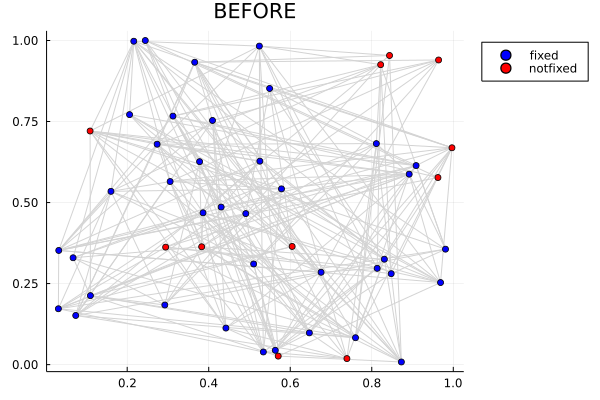

11

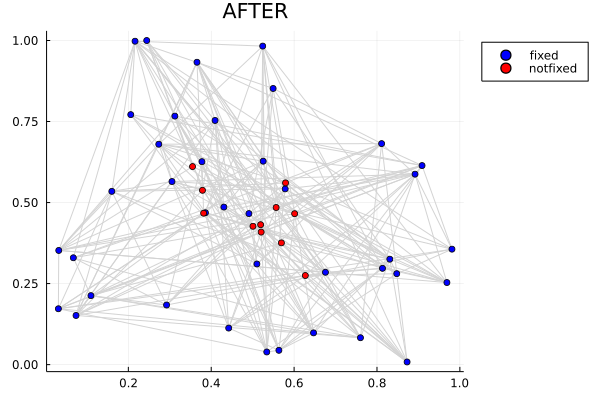

In [15]:
vlozitev_grafa(50, 0.2, 0, 0) # naključen graf s 50 vozlišči, nefiksna vozlišča izbrana tako da si niso sosednja

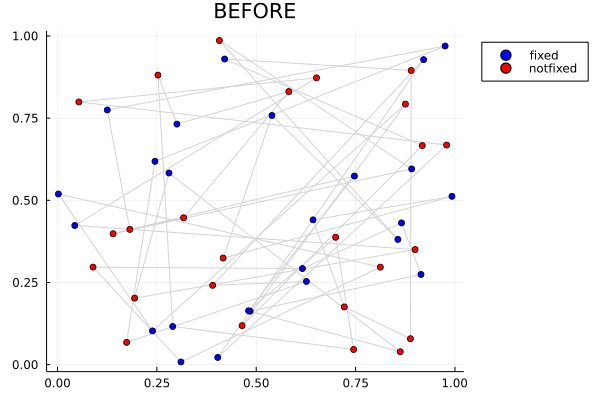

25

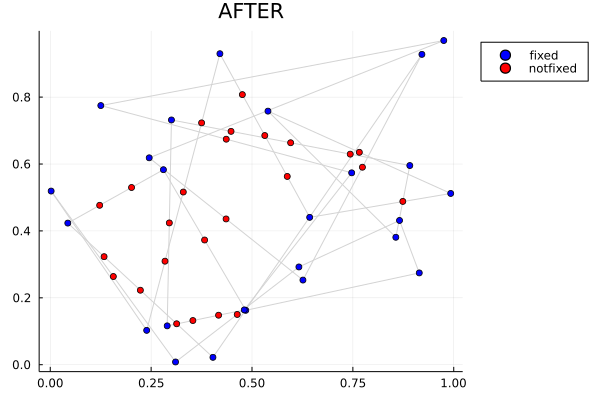

In [16]:
vlozitev_grafa(50, 5, 1, 4) # cikličen graf s 50 vozlišči, naključna nefiksna vozlišča